In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import torch.nn as nn
import torch as torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report


from catboost import CatBoostClassifier

from torch import tensor
from torch import optim

import copy
import warnings

from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('train.csv')

In [3]:
target = df["target"]
df = df.drop(labels="target", axis = 1);
df.insert(0, "target", target)

In [4]:
label = list(df.columns.values)
n,p = df.shape
print(label)
print(n,p)

['target', 'id', 'AP', 'creation_date_answer', 'situation', 'ctc', 'location', 'gc_id', 'gc_label', 'creation_date_global', 'id_group', 'id_group_2', 'favorite_fruit', 'fruit_situation_id', 'fruit_situation_label', 'fruits_or_vegetables', 'number_of_fruit', 'id_group_3', 'creation_date_request', 'hobby', 'id_group_4', 'ville', 'green_vegetables', 'vegetable_type']
25000 24


In [5]:
print("Suppression des colonnes NA")

to_delete=[]

for l in label:
    count_NA = df[l].isna().sum()
    if(count_NA>0):
        print(l+ ":  " + str(count_NA))
        to_delete.append(l)

df = df.drop(labels=to_delete, axis = 1);

Suppression des colonnes NA
ctc:  15380
fruit_situation_label:  1728
fruits_or_vegetables:  17341
ville:  16912
vegetable_type:  24586


In [6]:
print("Suppression des colonnes non exploitables")

df = df.drop(labels=["id","id_group","id_group_2","id_group_3","id_group_4"], axis = 1);

Suppression des colonnes non exploitables


In [7]:
print("Colonnes contenant même info: gc_id & gc_label")
#print(df['gc_id'].value_counts())
#print(df['gc_label'].value_counts())
print("On en supprime une des deux: gc_label")
df=df.drop(columns =['gc_label']);

Colonnes contenant même info: gc_id & gc_label
On en supprime une des deux: gc_label


In [8]:
print(df["creation_date_answer"][0])

year_creation_date_answer = []
month_creation_date_answer = []
day_creation_date_answer = []
hour_creation_date_answer = []

for i in range(n):
    s = df["creation_date_answer"][i]
    
    year_creation_date_answer.append(int(s[0:4]))
    month_creation_date_answer.append(int(s[5:7]))
    day_creation_date_answer.append(int(s[8:10]))
    hour_creation_date_answer.append(int(s[11:13]))

print(year_creation_date_answer[0],month_creation_date_answer[0],day_creation_date_answer[0],hour_creation_date_answer[0])

df=df.drop(columns =['creation_date_answer']);
df['year_creation_date_answer'] = year_creation_date_answer
df['month_creation_date_answer'] = month_creation_date_answer
df['day_creation_date_answer'] = day_creation_date_answer
df['hour_creation_date_answer'] = hour_creation_date_answer

2019-03-13 11:14:42.549
2019 3 13 11


In [9]:
print(df["creation_date_global"][0])

year_creation_date_global = []
month_creation_date_global = []
day_creation_date_global = []
hour_creation_date_global = []

for i in range(n):
    s = df["creation_date_global"][i]
    
    year_creation_date_global.append(int(s[0:4]))
    month_creation_date_global.append(int(s[5:7]))
    day_creation_date_global.append(int(s[8:10]))
    hour_creation_date_global.append(int(s[11:13]))

print(year_creation_date_global[0],month_creation_date_global[0],day_creation_date_global[0],hour_creation_date_global[0])

df=df.drop(columns =['creation_date_global']);
df['year_creation_date_global'] = year_creation_date_global
df['month_creation_date_global'] = month_creation_date_global
df['day_creation_date_global'] = day_creation_date_global
df['hour_creation_date_global'] = hour_creation_date_global

2019-01-17 10:50:57.767
2019 1 17 10


In [10]:
print(df["creation_date_request"][0])

year_creation_date_request = []
month_creation_date_request = []
day_creation_date_request = []
hour_creation_date_request = []

for i in range(n):
    s = df["creation_date_request"][i]
    
    year_creation_date_request.append(int(s[0:4]))
    month_creation_date_request.append(int(s[5:7]))
    day_creation_date_request.append(int(s[8:10]))
    hour_creation_date_request.append(int(s[11:13]))

print(year_creation_date_request[0],month_creation_date_request[0],day_creation_date_request[0],hour_creation_date_request[0])

df=df.drop(columns =['creation_date_request']);
df['year_creation_date_request'] = year_creation_date_request
df['month_creation_date_request'] = month_creation_date_request
df['day_creation_date_request'] = day_creation_date_request
df['hour_creation_date_request'] = hour_creation_date_request

2019-03-13 11:14:42.549
2019 3 13 11


In [11]:
label = list(df.columns.values)
n,p = df.shape
print(n,p)
print(label)

25000 22
['target', 'AP', 'situation', 'location', 'gc_id', 'favorite_fruit', 'fruit_situation_id', 'number_of_fruit', 'hobby', 'green_vegetables', 'year_creation_date_answer', 'month_creation_date_answer', 'day_creation_date_answer', 'hour_creation_date_answer', 'year_creation_date_global', 'month_creation_date_global', 'day_creation_date_global', 'hour_creation_date_global', 'year_creation_date_request', 'month_creation_date_request', 'day_creation_date_request', 'hour_creation_date_request']


In [12]:
print("Suppression des colonnes 1 occurence")

to_delete=[]

for l in label:
    count_occ = df[l].nunique()
    print(l+": "+str(count_occ))
    if(count_occ == 1): to_delete.append(l)

df = df.drop(labels=to_delete, axis = 1);
print("\n")
print("Deleted columns:", to_delete)

Suppression des colonnes 1 occurence
target: 4
AP: 2
situation: 8
location: 99
gc_id: 12
favorite_fruit: 2
fruit_situation_id: 22
number_of_fruit: 9
hobby: 3
green_vegetables: 2
year_creation_date_answer: 1
month_creation_date_answer: 3
day_creation_date_answer: 31
hour_creation_date_answer: 24
year_creation_date_global: 9
month_creation_date_global: 12
day_creation_date_global: 31
hour_creation_date_global: 24
year_creation_date_request: 1
month_creation_date_request: 3
day_creation_date_request: 31
hour_creation_date_request: 24


Deleted columns: ['year_creation_date_answer', 'year_creation_date_request']


In [13]:
label = list(df.columns.values)
n,p = df.shape
print(n,p)
print(label)

25000 20
['target', 'AP', 'situation', 'location', 'gc_id', 'favorite_fruit', 'fruit_situation_id', 'number_of_fruit', 'hobby', 'green_vegetables', 'month_creation_date_answer', 'day_creation_date_answer', 'hour_creation_date_answer', 'year_creation_date_global', 'month_creation_date_global', 'day_creation_date_global', 'hour_creation_date_global', 'month_creation_date_request', 'day_creation_date_request', 'hour_creation_date_request']


In [14]:
#One hot encoding

str_lab=[]

for l in label:
    if(type(df[l][0])==type("a")):
        #print(l+": "+str(type(df[l][0])))
        str_lab.append(l)
        
for l in str_lab:
    col = df[l].unique()
    col_count = df[l].value_counts()
    n_occ = len(col)
    n_cols = 0
    print(col_count/n*100, "\n")
    for i in range(n_occ):
        if(col_count[i]/n > 0.05): 
            n_cols = n_cols + 1
            new_col = (df[l] == col[i]).astype(float)
            df[l+"_"+str(i)] = new_col
            print("Nouvelle colonne: "+l+"_"+str(i))
    if (n_cols == n_occ):
        print("Nouvelle colonne à supprimer: " + l+"_"+str(np.argmin(col_count)))
        df = df.drop(labels = l+"_"+str(np.argmin(col_count)), axis = 1)
    df = df.drop(labels=l, axis = 1);
    print("\n","-"*50,"\n")

f    99.656
t     0.344
Name: AP, dtype: float64 

Nouvelle colonne: AP_0

 -------------------------------------------------- 

clementine    72.588
poire         27.412
Name: favorite_fruit, dtype: float64 

Nouvelle colonne: favorite_fruit_0
Nouvelle colonne: favorite_fruit_1
Nouvelle colonne à supprimer: favorite_fruit_1

 -------------------------------------------------- 

football      98.644
volleyball     1.240
noball         0.116
Name: hobby, dtype: float64 

Nouvelle colonne: hobby_0

 -------------------------------------------------- 

f    98.256
t     1.744
Name: green_vegetables, dtype: float64 

Nouvelle colonne: green_vegetables_0

 -------------------------------------------------- 



In [15]:
label = list(df.columns.values)
n,p = df.shape
print(n,p)
print(label)

25000 20
['target', 'situation', 'location', 'gc_id', 'fruit_situation_id', 'number_of_fruit', 'month_creation_date_answer', 'day_creation_date_answer', 'hour_creation_date_answer', 'year_creation_date_global', 'month_creation_date_global', 'day_creation_date_global', 'hour_creation_date_global', 'month_creation_date_request', 'day_creation_date_request', 'hour_creation_date_request', 'AP_0', 'favorite_fruit_0', 'hobby_0', 'green_vegetables_0']


In [16]:
corr=df.corr()
#plt.matshow(corr)
corr.style.background_gradient(cmap='coolwarm')

,target,situation,location,gc_id,fruit_situation_id,number_of_fruit,month_creation_date_answer,day_creation_date_answer,hour_creation_date_answer,year_creation_date_global,month_creation_date_global,day_creation_date_global,hour_creation_date_global,month_creation_date_request,day_creation_date_request,hour_creation_date_request,AP_0,favorite_fruit_0,hobby_0,green_vegetables_0
target,1.000000,0.001983,-0.020473,0.041049,-0.412233,0.037076,-0.049360,-0.014224,-0.107345,-0.084534,0.117298,0.026336,-0.021385,-0.049506,-0.013912,-0.108013,0.000345,0.041094,0.002765,-0.042520
situation,0.001983,1.000000,-0.024445,0.118824,-0.006258,0.314255,0.001087,0.000651,-0.038102,0.006642,0.003265,0.010500,0.006814,0.001095,0.000658,-0.038029,0.009699,0.147834,0.008062,-0.074065
location,-0.020473,-0.024445,1.000000,-0.022510,0.060436,-0.036544,0.000303,0.003274,0.135059,0.017465,0.003516,-0.027087,0.103698,0.000311,0.003190,0.135819,-0.008646,-0.027014,0.007058,-0.001110
gc_id,0.041049,0.118824,-0.022510,1.000000,-0.026021,0.219846,0.009773,-0.001890,-0.069280,0.073431,-0.005851,0.001432,0.069471,0.009803,-0.001850,-0.069218,0.024867,0.747461,0.012501,-0.007211
fruit_situation_id,-0.412233,-0.006258,0.060436,-0.026021,1.000000,-0.011165,0.033383,0.012893,0.127785,0.077426,-0.098038,-0.028500,0.013556,0.033447,0.012788,0.127892,0.012454,-0.003586,-0.005561,0.038643
number_of_fruit,0.037076,0.314255,-0.036544,0.219846,-0.011165,1.000000,0.000240,-0.003666,-0.063322,-0.110291,0.025859,-0.009882,-0.088315,0.000264,-0.003662,-0.062961,0.002546,0.233650,0.005114,-0.057488
month_creation_date_answer,-0.049360,0.001087,0.000303,0.009773,0.033383,0.000240,1.000000,-0.024390,-0.015000,0.129958,-0.137524,-0.009398,0.003342,0.999971,-0.024255,-0.014856,0.009799,0.004798,0.014409,-0.001743
day_creation_date_answer,-0.014224,0.000651,0.003274,-0.001890,0.012893,-0.003666,-0.024390,1.000000,0.010777,0.055453,-0.072833,0.105109,-0.004872,-0.024397,0.999892,0.010586,0.007960,0.003107,-0.004254,-0.005699
hour_creation_date_answer,-0.107345,-0.038102,0.135059,-0.069280,0.127785,-0.063322,-0.015000,0.010777,1.000000,0.048549,-0.055194,0.010352,0.183309,-0.015124,0.010726,0.999008,0.006546,-0.083404,-0.010026,0.016235
year_creation_date_global,-0.084534,0.006642,0.017465,0.073431,0.077426,-0.110291,0.129958,0.055453,0.048549,1.000000,-0.607195,-0.083005,0.317246,0.129973,0.055380,0.048389,0.032864,0.080329,-0.002747,-0.016684


In [17]:
df.to_csv('train_clean.csv')

In [18]:
X_=df.iloc[:,1:].to_numpy()
y_=df['target'].to_numpy()

n,p=X_.shape

X, X_test, y, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42,stratify=y_)

n_train=y.size
n_test=y_test.size
n_class=np.unique(y).size

X = (X-np.mean(X,axis=0))/np.std(X,axis=0)
X_test = (X_test-np.mean(X_test,axis=0))/np.std(X_test,axis=0)

#matrice des probas
lb = LabelBinarizer().fit(y)
Y = lb.transform(y) 
Y_test = lb.transform(y_test) 

print("Shape of train X,y,Y: ",X.shape,y.shape,Y.shape)
print("Shape of test X,y,Y: ",X_test.shape,y_test.shape,Y_test.shape)
print("Number of classes: ",n_class)

Shape of train X,y,Y:  (20000, 19) (20000,) (20000, 4)
Shape of test X,y,Y:  (5000, 19) (5000,) (5000, 4)
Number of classes:  4


In [19]:
#'''
clf_reg = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=3000, tol=1e-5, class_weight="balanced")
clf_reg = clf_reg.fit(X, y)

Y_hat_regLoss = clf_reg.predict_proba(X)
Y_hat_test_regLoss = clf_reg.predict_proba(X_test)


print("Train Loss (Reg Loss):",log_loss(Y,Y_hat_regLoss))
print("\n")
print("Test Loss (Reg Loss): ",log_loss(Y_test,Y_hat_test_regLoss))
print("Test Loss (Proba unif): ",log_loss(Y_test,np.ones((n_test,4))*0.25))
#''';

Train Loss (Reg Loss): 1.1654788198821142


Test Loss (Reg Loss):  1.1809958647733108
Test Loss (Proba unif):  1.3862943611198908


In [20]:
clf_catboost = CatBoostClassifier(loss_function="MultiClass",learning_rate=0.1,n_estimators=100,max_depth=3, verbose = 0, auto_class_weights="Balanced")
clf_catboost = clf_catboost.fit(X, y)

Y_hat_boosting=clf_catboost.predict_proba(X)
Y_hat_test_boosting=clf_catboost.predict_proba(X_test)

print("Train Loss (Catboost):",log_loss(Y,Y_hat_boosting))
print("\n")
print("Test Loss (Catboost): ",log_loss(Y_test,Y_hat_test_boosting))
print("Test Loss (Reg Loss): ",log_loss(Y_test,Y_hat_test_regLoss))
print("Test Loss (Proba unif): ",log_loss(Y_test,np.ones((n_test,4))*0.25))

Train Loss (Catboost): 1.0493612777177765


Test Loss (Catboost):  1.1609884178128544
Test Loss (Reg Loss):  1.1809958647733108
Test Loss (Proba unif):  1.3862943611198908


In [21]:
# model definition
class MLP(nn.Module):
    # define model elements
    def __init__(self):
        super(MLP, self).__init__()
        # input to first hidden layer
        self.hidden1 = nn.Linear(p, 128)
        nn.init.xavier_normal_(self.hidden1.weight)
        self.act1 = nn.ReLU()
        
        self.hidden2 = nn.Linear(128, n_class)
        nn.init.xavier_normal_(self.hidden2.weight)
        #self.act2 = nn.ReLU()
        
        #self.hidden3 = nn.Linear(64, 32)
        #nn.init.xavier_normal_(self.hidden3.weight)
        #self.act3 = nn.ReLU()
        
        #self.hidden4 = nn.Linear(32, n_class)
        #nn.init.xavier_normal_(self.hidden4.weight)
        

    # forward propagate input
    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)
        
        X = self.hidden2(X)
        #X = self.act2(X)
        
        #X = self.hidden3(X)
        #X = self.act3(X)
        
        #X = self.hidden4(X)
        return X

In [22]:
def train_model(X, y, model, n_epochs = 200, learning_rate=0.1, l2_regularization=0, batch_size = n_train, class_weight=None, early_stopping=None, track_F1=False, verbose=50):
    track_loss_train = []
    track_loss_test = []
    if(track_F1):
        track_F1_train = []
        track_F1_test = []
    
    stopping_cond = False
    criterion = nn.CrossEntropyLoss(weight=class_weight)
    #optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_regularization)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_regularization)

    for epoch in range(n_epochs):
        Y_hat = model(X)
        
        loss = criterion(Y_hat, y)      
        
        track_loss_train.append(loss.item())
        track_loss_test.append(evaluate_model(X_test, y_test, copy.deepcopy(clf_mlp), class_weight=class_weight))
        if(track_F1):   
            track_F1_train.append(evaluate_model_score(X, y, copy.deepcopy(clf_mlp)))
            track_F1_test.append(evaluate_model_score(X_test, y_test, copy.deepcopy(clf_mlp)))
        
        if (epoch == 0): best_params = copy.deepcopy(model.state_dict())
        elif (track_loss_test[epoch] < np.min(track_loss_test[0:epoch])): best_params = copy.deepcopy(model.state_dict())
        
        if(early_stopping and (epoch > early_stopping)):
            stopping_cond = ((np.min(track_loss_test[epoch-early_stopping:epoch+1])) > (np.min(track_loss_test[:epoch-early_stopping]))) \
            & ((np.max(track_F1_test[epoch-early_stopping:epoch+1])) < (np.max(track_F1_test[:epoch-early_stopping])))
        if(stopping_cond) : 
            print("/!\ Early Stopping")
            break
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if(not(epoch%verbose)):
            print("Epoch:",epoch)
            print("Train loss=", track_loss_train[epoch])
            print("Test loss=", track_loss_test[epoch])
            print("-"*80)
    
    if(track_F1): return track_loss_train, track_loss_test, track_F1_train, track_F1_test, best_params
    else: return track_loss_train, track_loss_test, best_params

    
def evaluate_model(X , y_true, model, class_weight = None):
    criterion = nn.CrossEntropyLoss(weight = class_weight)
    Y_hat = model(X)
    loss = criterion(Y_hat, y_true)
    return loss.item()

def evaluate_model_score(X , y_true, model):
    to_prob=nn.Softmax(dim=1)
    Y_hat = to_prob(model(X)).detach().numpy()
    y_hat = np.argmax(Y_hat, axis=1)
    
    return f1_score(y_true, y_hat, average='weighted')

In [23]:
warnings.filterwarnings('ignore')

# data
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).long()

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).long()

count = np.unique(y, return_counts=True)[1]
weight = torch.tensor((count[np.argmax(count)]/count), dtype=torch.float32)

# define the network
clf_mlp = MLP()
print(clf_mlp)

MLP(
  (hidden1): Linear(in_features=19, out_features=128, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=128, out_features=4, bias=True)
)


In [24]:
# train the model
n_epochs = 500
track_loss_train, track_loss_test, track_F1_train, track_F1_test, best_params = train_model(X, y, clf_mlp, 
                                                                                            n_epochs = n_epochs, 
                                                                                            learning_rate = 0.1, 
                                                                                            l2_regularization = 0.01, 
                                                                                            class_weight = weight,
                                                                                            early_stopping = 100,
                                                                                            verbose = n_epochs//50, track_F1 = True)

clf_best_mlp = MLP()
clf_best_mlp.load_state_dict(best_params)

print("\n", "-"*50, "\n")
print("Final results:\n")
print("Train loss:",evaluate_model(X, y, clf_best_mlp, class_weight=None))
print("\n")
print("Test loss: ",evaluate_model(X_test, y_test, clf_best_mlp, class_weight=None))

Epoch: 0
Train loss= 1.5610287189483643
Test loss= 1.5735501050949097
--------------------------------------------------------------------------------
Epoch: 10
Train loss= 1.3284519910812378
Test loss= 1.3337652683258057
--------------------------------------------------------------------------------
Epoch: 20
Train loss= 1.271893858909607
Test loss= 1.2835698127746582
--------------------------------------------------------------------------------
Epoch: 30
Train loss= 1.242648720741272
Test loss= 1.2613904476165771
--------------------------------------------------------------------------------
Epoch: 40
Train loss= 1.2249469757080078
Test loss= 1.250339388847351
--------------------------------------------------------------------------------
Epoch: 50
Train loss= 1.2132728099822998
Test loss= 1.2444819211959839
--------------------------------------------------------------------------------
Epoch: 60
Train loss= 1.2050758600234985
Test loss= 1.2413305044174194
---------------------

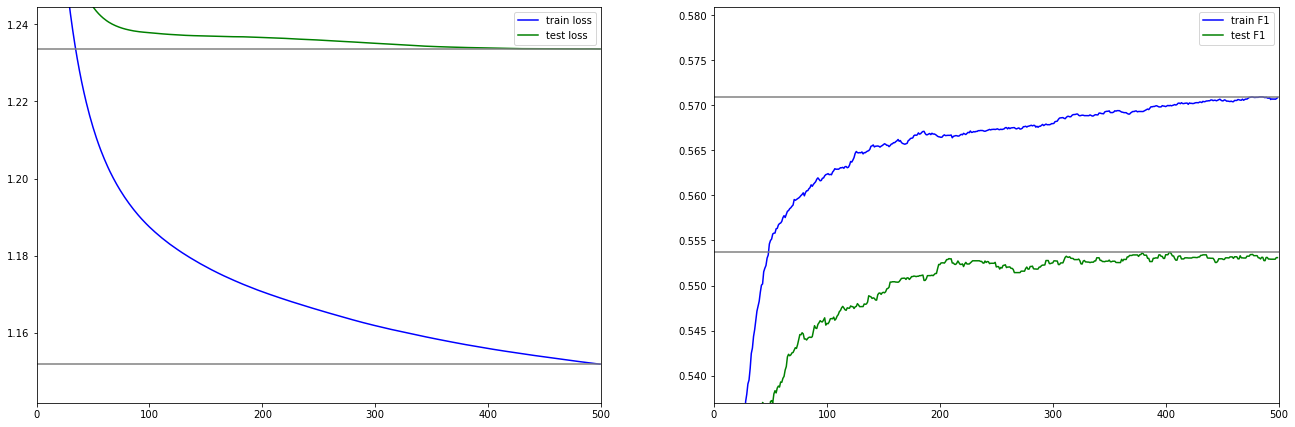

In [25]:
n_iter = len(track_loss_train)

fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2)

ax0.plot(np.arange(0,n_iter), track_loss_train, color = "blue", label="train loss")
ax0.plot(np.arange(0,n_iter), track_loss_test, color = "green", label="test loss")
ax0.set_xlim(0,n_iter)
ax0.set_ylim(np.min(track_loss_train)-0.01,np.max(track_loss_test[n_epochs//10:]))
ax0.axhline(y=np.min(track_loss_train), color="grey")
ax0.axhline(y=np.min(track_loss_test), color="grey")
ax0.legend()

ax1.plot(np.arange(0,n_iter), track_F1_train, color = "blue", label="train F1")
ax1.plot(np.arange(0,n_iter), track_F1_test, color = "green", label="test F1")
ax1.set_xlim(0,n_iter)
ax1.set_ylim(np.min(track_F1_test[n_epochs//10:]),np.max(track_F1_train)+0.01)
ax1.axhline(y=np.max(track_F1_train), color="grey")
ax1.axhline(y=np.max(track_F1_test), color="grey")
ax1.legend()



plt.subplots_adjust(left=None, bottom=None, right=3, top=1.5, wspace=0.2, hspace=None)

In [26]:
to_prob=nn.Softmax(dim=1)
Y_hat_mlp = to_prob(clf_best_mlp(X)).detach().numpy()
Y_hat_test_mlp = to_prob(clf_best_mlp(X_test)).detach().numpy()

print("Train Loss (MLP):",log_loss(Y,Y_hat_mlp))
print("\n")
print("Test Loss (MLP): ",log_loss(Y_test, Y_hat_test_mlp))
print("Test Loss (Catboost): ",log_loss(Y_test,Y_hat_test_boosting))
print("Test Loss (Reg Loss): ",log_loss(Y_test,Y_hat_test_regLoss))
print("Test Loss (Proba unif): ",log_loss(Y_test,np.ones((n_test,4))*0.25))

Train Loss (MLP): 1.1308042361103


Test Loss (MLP):  1.1468684289932252
Test Loss (Catboost):  1.1609884178128544
Test Loss (Reg Loss):  1.1809958647733108
Test Loss (Proba unif):  1.3862943611198908


In [27]:
print("Test F1-score (MLP): ",f1_score(y_test, np.argmax(Y_hat_test_mlp,axis=1), average='weighted'))
print("Test F1-score (Catboost): ",f1_score(y_test,np.argmax(Y_hat_test_boosting,axis=1), average='weighted'))
print("Test F1-score (Reg Loss): ",f1_score(y_test,np.argmax(Y_hat_test_regLoss,axis=1), average='weighted'))
print("Test F1-score (Proba unif): ",f1_score(y_test,np.random.randint(0,4,n_test), average='weighted'))
print("-"*80)
print("Perf MLP:")
print(classification_report(y_test, np.argmax(Y_hat_test_mlp,axis=1)))

Test F1-score (MLP):  0.5530980559836631
Test F1-score (Catboost):  0.5393430832651406
Test F1-score (Reg Loss):  0.5483682320022408
Test F1-score (Proba unif):  0.2942601130204552
--------------------------------------------------------------------------------
Perf MLP:
              precision    recall  f1-score   support

           0       0.68      0.77      0.72      2415
           1       0.59      0.47      0.52      1763
           2       0.26      0.08      0.12       775
           3       0.03      0.43      0.06        47

    accuracy                           0.55      5000
   macro avg       0.39      0.44      0.36      5000
weighted avg       0.58      0.55      0.55      5000



In [32]:
X_stack = np.column_stack((Y_hat_mlp[:,:-1], Y_hat_boosting[:,:-1]))
X_stack_test = np.column_stack((Y_hat_test_mlp[:,:-1], Y_hat_test_boosting[:,:-1]))


clf_stack = LogisticRegressionCV(penalty= "l2", solver='lbfgs', max_iter=5000, tol=1e-7, class_weight="balanced")
#clf_stack = LogisticRegressionCV(penalty="elasticnet", l1_ratios= np.linspace(0,1,4), solver='saga', max_iter=100, tol=1e-3, class_weight="balanced", scoring="f1_weighted")

clf_stack = clf_stack.fit(X_stack, y.numpy())

Y_hat_stack = clf_stack.predict_proba(X_stack)
Y_hat_test_stack = clf_stack.predict_proba(X_stack_test)


print("Train Loss (Stack):",log_loss(Y,Y_hat_stack))
print("\n")
print("Test Loss (Stack): ",log_loss(Y_test,Y_hat_test_stack))
print("\n")
print(classification_report(y_test, np.argmax(Y_hat_test_stack,axis=1)))

Train Loss (Stack): 1.120724539195578


Test Loss (Stack):  1.2084428404762082


              precision    recall  f1-score   support

           0       0.70      0.70      0.70      2415
           1       0.64      0.35      0.46      1763
           2       0.25      0.46      0.32       775
           3       0.13      0.38      0.19        47

    accuracy                           0.54      5000
   macro avg       0.43      0.48      0.42      5000
weighted avg       0.60      0.54      0.55      5000

